# A Simple Model of American COVID Deaths

Let us start by importing some libraries and a few functions from a utils python file that I creates. There is not that much intresting in that file, just some helper functions that I wrote to help import the csv datasets as np.arrays and some other functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats
from matplotlib.widgets import Slider

from Utils import *
USCases,GlobalCases,USDeaths,GlobalDeaths = get_data()

For our model the probabilty that a single coranvirus patient dies is Bernoulli random variable with parameter $p_{death}$. If a patient is going to die, then the time it will take for him/her to die is a Poisson random variable with parameter $\lambda$. Thus $\hat{d_{n}}$, the predicted number of new deaths for day n, can be mathmatically expressed as: $$\hat{d_{n}}=\sum_{i=1}^{n} (p_{death}\cdot poisson(n-i,\lambda)\cdot c(i))$$ Where $c(i)$ is the number of new cases for day $i$ and $poisson(x,\lambda)$ is the pmf for a Poisson random variable with parameter $\lambda$ at $x$, i.e: $$poisson(c,\lambda)=\frac{\lambda^{x}\cdot^{-\lambda}}{x!}$$ 

In order to understand how $p_{death}$ and $\lambda$ influnce the predicted number of deaths, let us write a function that plots out the predicted deaths, actual deaths and actual cases, with sliders for $p_{death}$ and for $\lambda$.

In [27]:
def get_predicted_delta_deaths(delta_cases,p_death,Lambda):
    """
    a helper function that returns an np.array of the predicted new_deaths each day
    """
    p_array=np.zeros((delta_cases.shape[0],delta_cases.shape[0]))
    for n in range(delta_cases.shape[0]):
        
        p_array+=np.diag(np.full((delta_cases.shape[0]-n,),stats.poisson.pmf(n,Lambda)),k=n)
    return p_death*np.matmul(delta_cases,p_array)
    

def plot_predicted_delta_deaths(delta_deaths,delta_cases,title,start_date='1/23/20',p_death_init=0.02,
                                lambda_init=6):
    """
    plots out a figure with a subplot and two sliders, p_death and lambda,
    """
    %matplotlib notebook
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)
    ax.margins(x=0)
    
    plt.title(title)
    plt.ylabel('new deaths')
    plt.grid()
    
    x=np.arange(0,delta_deaths.shape[0],1)
    r, =plt.plot(x,delta_deaths,c='k',label="actual new deaths")
    p, =plt.plot(x,get_predicted_delta_deaths(delta_cases,p_death_init,lambda_init),c='r',
                label="predicted new deaths")
    plt.legend(loc='upper left')
    ticks, dates= make_ticks(start_date,n_days=delta_deaths.shape[0],step=40)
    plt.xticks(ticks, dates)
    
    
    axlambda = plt.axes([0.25, 0.05, 0.65, 0.03])
    slider_p_death=Slider(axlambda, "p_death",0,0.2,valinit=p_death_init,valstep=0.001)
        
        
    axp_death = plt.axes([0.25, 0.1, 0.65, 0.03])
    slider_lambda = Slider(axp_death, "lambda",1,30,valinit=lambda_init,valstep=1)
    
    def update(val):
        Lambda=slider_lambda.val
        p_death=slider_p_death.val
        print(p_death)
        p.set_ydata(get_predicted_delta_deaths(delta_cases,p_death,Lambda))
        
        fig.canvas.draw_idle()
    
    slider_p_death.on_changed(update)
    slider_lambda.on_changed(update)
    
    plt.show()
    return slider_p_death, slider_lambda

<IPython.core.display.Javascript object>


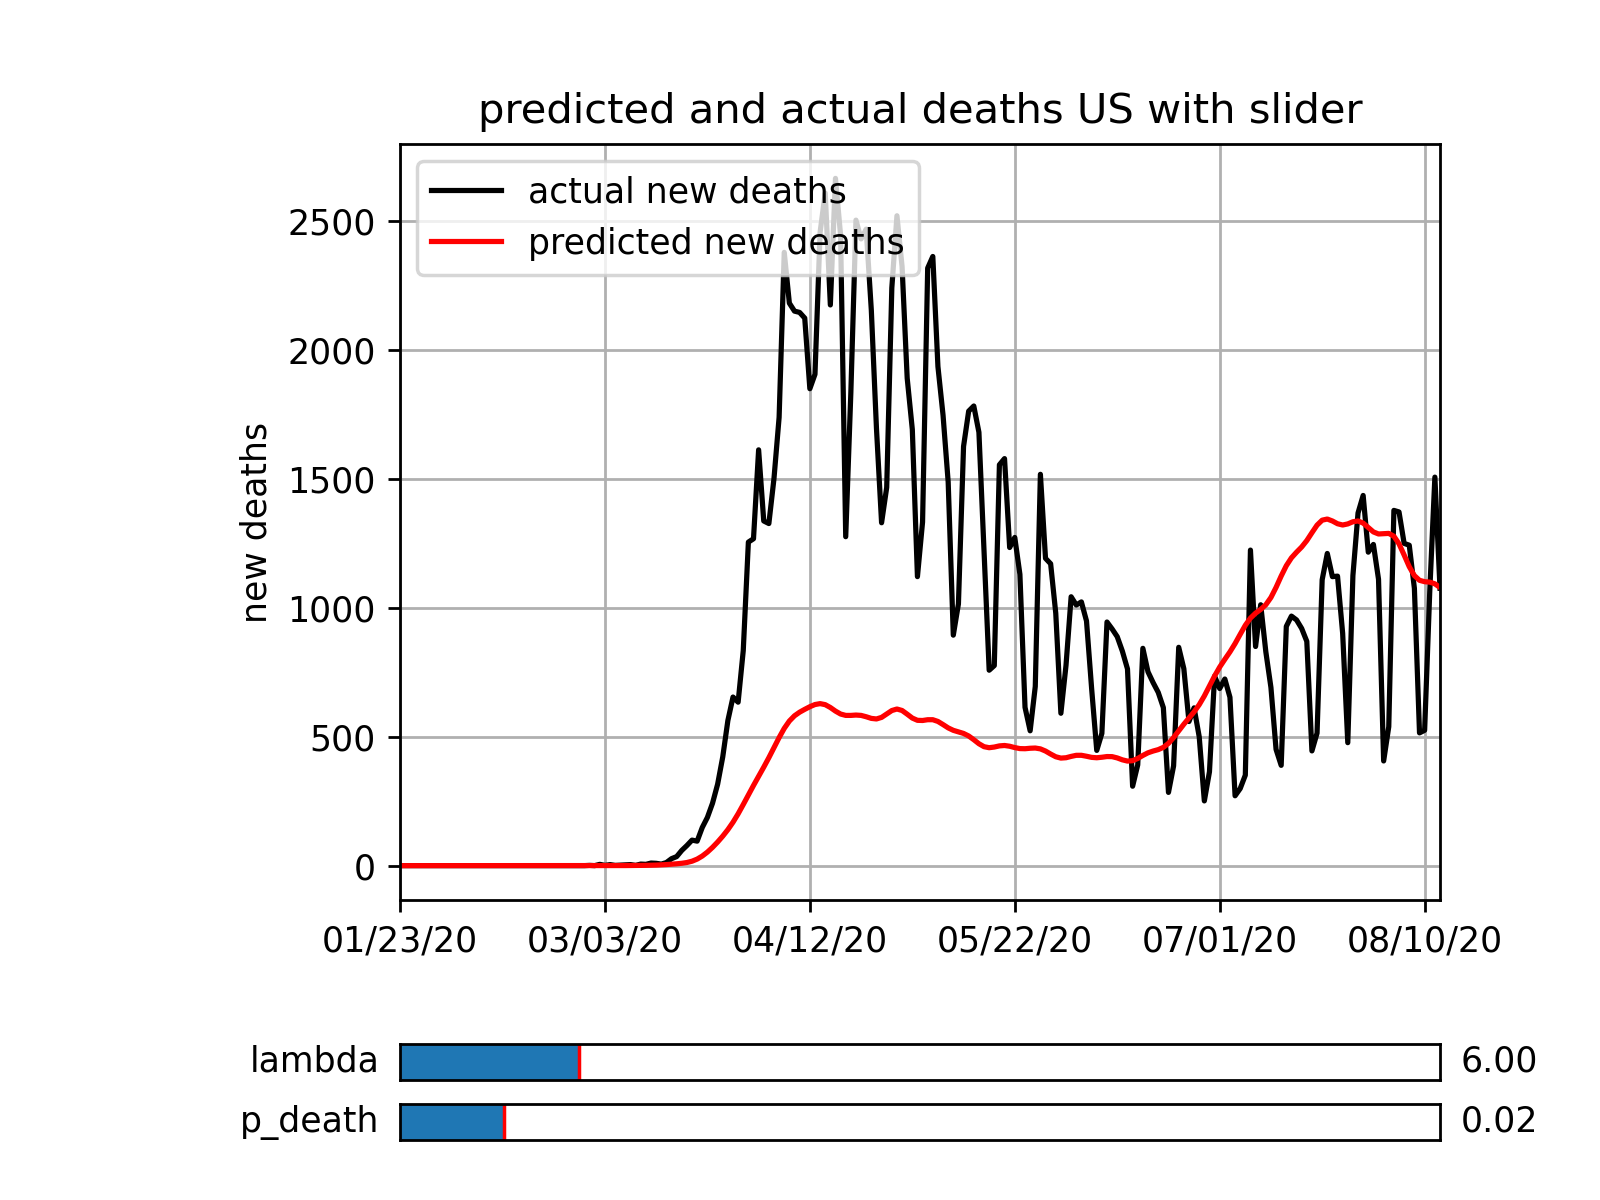

In [28]:
USdeltadeaths=get_delta(get_deaths(USDeaths,GlobalDeaths,'US'))
USdeltacases=get_delta(get_cases(USCases,GlobalCases,'US'))
keepslider_p_death,keepslider_lambda=plot_predicted_delta_deaths(USdeltadeaths,USdeltacases,'predicted and actual deaths US with slider')

Since $p_{death} \in [0,1]$ and $\lambda \in (0,\infty)$ we can define them in terms of two other variables $p$ and $l$. $$p_{death}=\frac{1}{1+e^{-p}}$$ $$\lambda=e^{l}$$ This way $p \in (-\infty,\infty)$ and $l \in (-\infty,\infty)$

In [5]:
class p_death_simple(object):
    def __init__(self,p_death_init_value):
        self.p=-np.log((1/p_death_init_value)-1)
    def get_p_death(self):
        return 1/(1+np.exp(-self.p))
    def derivative(self):
        return 1/((1+np.exp(-self.p))*(1+np.exp(self.p)))
    def update_p(self, dloss, learning_rate):
        self.p-=learning_rate*np.mean(dloss)*self.derivative()
    
class Lambda(object):
    def __init__(self,lambda_init):
        self.l=np.log(lambda_init)
    def get_lambda(self):
        return np.exp(self.l)
    def derivative(self):
        return np.exp(self.l)
    def update_l(self, dloss, learning_rate):
        self.l-=learning_rate*np.mean(dloss)*self.derivative()

Now, let's write a function to optimize $p$ and $l$ through Stochastic Gradient Descent. In order to do so we have to specify and write a loss function, for now we will use the absolute loss: $$loss(\hat{D},D)=\sum \frac{|\hat{D}-D|}{n}$$
where $\hat{D}$ and $D$ are the vectorized predicted and actual new deaths. For this loss function, $$\frac{\partial loss(\hat{D},D)}{\partial \hat{d_{i}}}=
  \begin{cases}
    \frac{1}{n}  & \text{if $\hat{d_{i}}-d_{i}>0$} \\
    \text{undefined, for our case we will let define it as $0$} & \text{if $\hat{d_{i}}-d_{i}=0$} \\
    \frac{-1}{n} & \text{if $\hat{d_{i}}-d_{i}<0$}
  \end{cases}
$$
where $\hat{d_{i}}$ and $d_{i}$ is the predicted and actual deaths for day $i$.

In [6]:
class Absolute_loss(object):
    def __init__(self,predicted,actual):
        """
        caculates the loss through the equation above and saves it as self.loss
        predicted and actual are both also saved along with n
        """
        self.n=predicted.shape[0]
        self.predicted=predicted
        self.actual=actual
        self.loss=np.mean(np.abs(self.predicted-self.actual))
    
    def dloss(self):
        """
        returns an array where each value is dloss/di for i in range from 1 to n
        """
        return np.sign(self.predicted-self.actual)/self.n
    def get_loss(self):
        """
        returns self.loss
        """
        return self.loss

After each iteration we would want to use stochastic gradient descent to update the parameters of the model, $p$ and $l$, such that the loss is minimized. Mathmatically the update equation for $p$ can be written as $$ p:=p-\frac{\eta}{n} \sum_{i=1}^{n} \frac{\partial}{\partial p} loss(\hat{d_{i}},d_{i}) $$ where $\eta$ is the learning rate. Due to the chain rule, we can rewrite this equation as: $$ p:=p-\frac{\eta}{n} \sum_{i=1}^{n} \frac{\partial loss(\hat{d_{i}},d_{i})}{\partial \hat{d_{i}}} \frac{\partial \hat{d_{i}}}{\partial p_{death}} \frac{\partial p_{death}}{\partial p} $$ Likewise the update equation for $l$: $$l:=l-\frac{\eta}{n}\sum_{i=1}^{n} \frac{\partial loss(\hat{d_{i}},d_{i})}{\partial l}$$ can be writen as: $$l:=l-\frac{\eta}{n}\sum_{i=1}^{n} \frac{\partial loss(\hat{d_{i}},d_{i})}{\partial \hat{d_{i}}} \frac{\partial \hat{d_{i}}}{\partial \lambda} \frac{\partial \lambda}{\partial l}$$ for any value of $i$: $$\frac{\partial \hat{d_{i}}}{\partial p_{death}}=\sum_{j=1}^{i} poisson(i-j,\lambda) \cdot c(j)$$ and $$\frac{\partial \hat{d_{i}}}{\partial \lambda}=\sum_{j=1}^{i} (\frac{i-j}{\lambda}-1) \cdot p_{death} \cdot poisson(i-j,\lambda) \cdot c(j)$$ where again $c(j)$ is the number of new cases on day $j$.

In [7]:
class model(object):
    def __init__(self,delta_cases,p_death_init,lambda_init):
        self.p_death=p_death_init
        
        self.Lambda=lambda_init
        self.new_cases=delta_cases
        self.hat_deaths=self.calculate_predicted_deaths(self.new_cases.shape[0]) 
        
    def calculate_predicted_deaths(self,n):
        """
        predicts the number of deaths for the first n days
        """
        p_death=self.p_death.get_p_death()
        
        Lambda=self.Lambda.get_lambda()
        
        p_array=np.zeros((n,n))
        for i in range(n):
            p_array+=np.diag(np.full((n-i,),stats.poisson.pmf(i,Lambda)),k=i)
        return np.matmul(np.multiply(p_death,self.new_cases),p_array)
    
    def dlambda(self):
        """
        gets the derivative (d hat_death)/(d_lambda)
        """
        n=self.new_cases.shape[0]
        p_death=self.p_death.get_p_death()
        Lambda=self.Lambda.get_lambda()
        p_array=np.zeros((n,n))
        for i in range(n):
            p_array+=np.diag(np.full((n-i,),(i/Lambda-1)*stats.poisson.pmf(i,Lambda)),k=i)
        return p_death*np.matmul(self.new_cases,p_array)
    
    def dp_death(self):
        """
        gets the derivative (d hat_death)/(d p_death)
        """
        return self.hat_deaths/self.p_death.get_p_death()
    
    def update(self,loss, learning_rate):
        dloss_dp_death=np.multiply(loss.dloss(),self.dp_death())
        dloss_dlambda=np.multiply(loss.dloss(),self.dlambda())
        
        
        
        self.p_death.update_p(dloss_dp_death,learning_rate)
        self.Lambda.update_l(dloss_dlambda,learning_rate)
        
        self.hat_deaths=self.calculate_predicted_deaths(self.new_cases.shape[0]) 
    
    def get_predicted_deaths(self):
        return self.hat_deaths

In order for our algorithim to optimize $p$ and $l$ (and thus $p_{death}$ and $\lambda$), we will have to loop this update function a number of times. For now, we will set the learning rate as $0.01$ and the epochs as $10$.


<IPython.core.display.Javascript object>


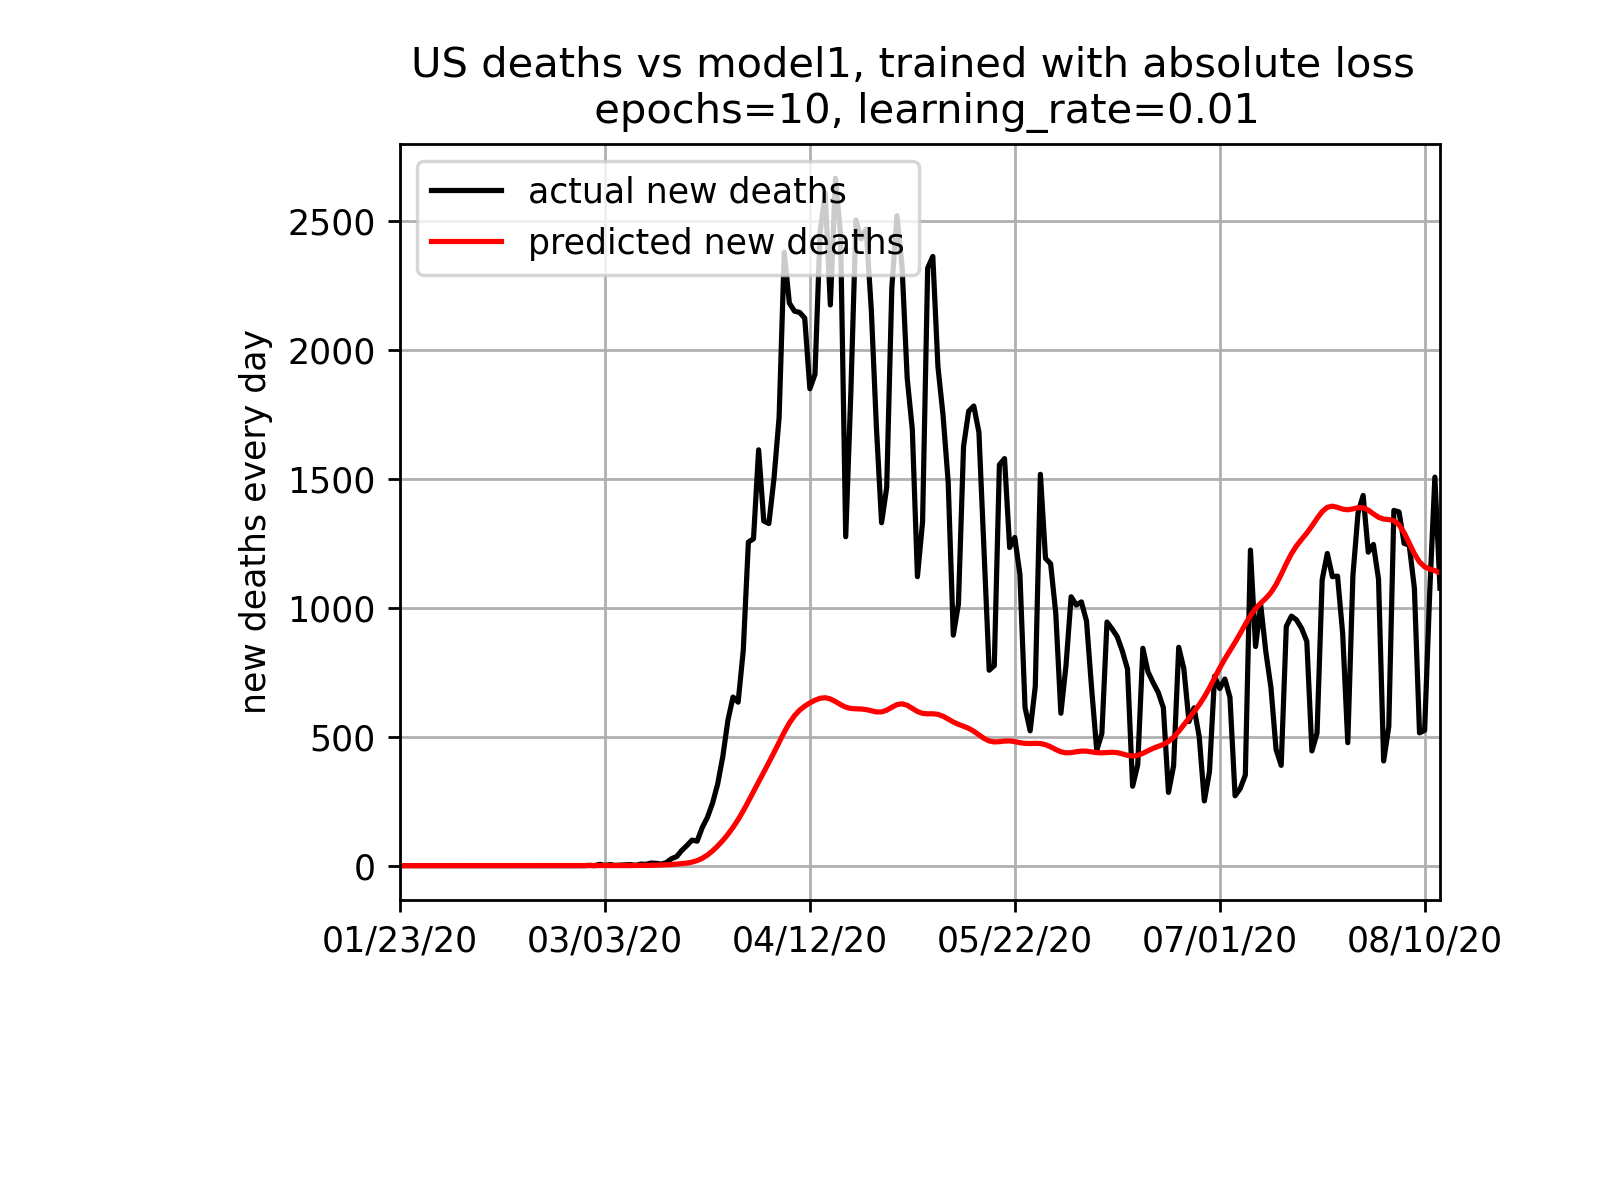

predicted p_death =  0.020835721919596626
predicted lambda =  6.9576497796700565
final loss is = 470.63695268219993


In [12]:
epochs=10
learning_rate=0.1

p_death=p_death_simple(0.02)
L=Lambda(7)
model1=model(USdeltacases,p_death,L)

for epoch in range(epochs):
    loss=Absolute_loss(model1.get_predicted_deaths(),USdeltadeaths)
    model1.update(loss, learning_rate)
    
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
ax.margins(x=0)
    
plt.title('US deaths vs model1, trained with absolute loss \n epochs=10, learning_rate=0.01')
plt.ylabel('new deaths every day')
plt.grid()
    
x=np.arange(0,USdeltadeaths.shape[0],1)
r, =plt.plot(x,USdeltadeaths,c='k',label="actual new deaths")
p, =plt.plot(x,model1.get_predicted_deaths(),c='r',
                label="predicted new deaths")
plt.legend(loc='upper left')
ticks, dates= make_ticks('1/23/20',n_days=USdeltadeaths.shape[0], step=40)
plt.xticks(ticks, dates)

print("predicted p_death = ",p_death.get_p_death())
print("predicted lambda = ", L.get_lambda())
print("final loss is =",loss.get_loss())

We can also implement a program plots out the models predictions vs the actual predictions with two sliders, one for the learning rate, and the second for the number of epochs i.e the number of times we are going to loop the update function.

<IPython.core.display.Javascript object>


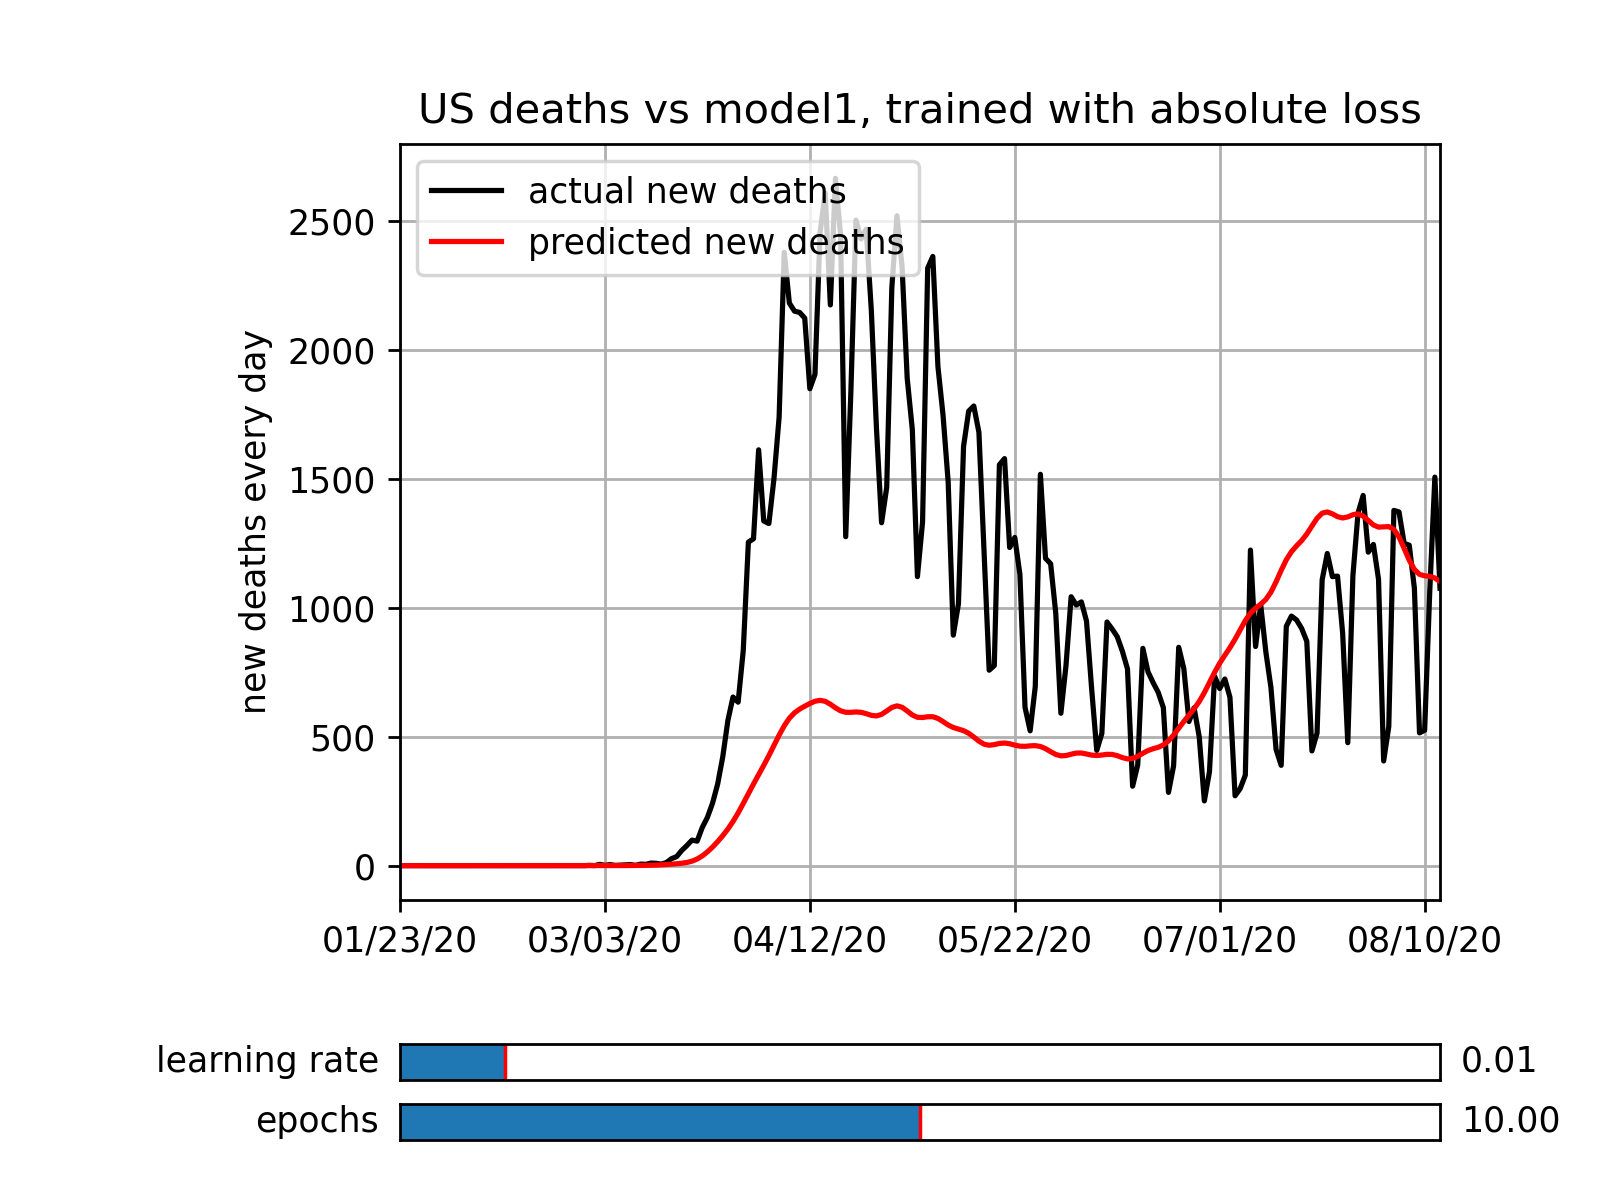

In [22]:
epoch_init=10
learning_rate_init=0.01

p_death=p_death_simple(0.02)
L=Lambda(6)
model2=model(USdeltacases,p_death,L)


for epoch in range(epoch_init):
    loss=Absolute_loss(model2.get_predicted_deaths(),USdeltadeaths)
    model2.update(loss, learning_rate_init)


%matplotlib notebook
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
ax.margins(x=0)
    
plt.title('US deaths vs model1, trained with absolute loss')
plt.ylabel('new deaths every day')
plt.grid()
    
x=np.arange(0,USdeltadeaths.shape[0],1)
r, =plt.plot(x,USdeltadeaths,c='k',label="actual new deaths")
p, =plt.plot(x,model2.get_predicted_deaths(),c='r',
                label="predicted new deaths")
plt.legend(loc='upper left')
ticks, dates= make_ticks('1/23/20',n_days=USdeltadeaths.shape[0], step=40)
plt.xticks(ticks, dates)

axepochs = plt.axes([0.25, 0.05, 0.65, 0.03])
slider_epochs=Slider(axepochs, "epochs",0,20,valinit=epoch_init,valstep=1)
                
axlearning_rate = plt.axes([0.25, 0.1, 0.65, 0.03])
slider_learning_rate = Slider(axlearning_rate, "learning rate",0.001,0.1,
                              valinit=learning_rate_init,valstep=0.01)

def update(val):
    
    learning_rate=slider_learning_rate.val
    epochs = slider_epochs.val
    
    p_death=p_death_simple(0.02)
    L=Lambda(6)
    model2=model(USdeltacases,p_death,L)
    epoch=0
    while epoch!=epochs:
        loss=Absolute_loss(model2.get_predicted_deaths(),USdeltadeaths)
        model2.update(loss, learning_rate)
        epoch+=1
        
    p.set_ydata(model2.get_predicted_deaths())
        
    fig.canvas.draw_idle()
    
slider_epochs.on_changed(update)
slider_learning_rate.on_changed(update)
plt.show()

We can also try differnt loss functions such as the variet of the quadratic loss function: $$loss(\hat{D},D)=\frac{1}{n} \sqrt{\sum_{i=1}^{n}(\hat{d_{i}}-d_{i})^{2}}$$ 

For this loss $$\frac{\partial loss(\hat{D},D)}{\partial \hat{d_{i}}}=\frac{(\hat{d_{i}}-d_{i})}{n \cdot \sqrt{\sum_{i=1}^{n}(\hat{d_{i}}-d_{i})^{2}}} $$
The reason we are going to use this loss function is because it penalizes larger devations heavier, relative to smaller devatiosn, more than for absolute loss.

In [17]:
class Quadratic_loss(object):
    def __init__(self,predicted,actual):
        self.n=predicted.shape[0] #acutally this could also be actual.shape[0] since these two arrays
        #are supposed to be of the same shape.
        self.predicted=predicted
        self.actual=actual
        self.loss=np.sqrt(np.mean(np.square(self.predicted-self.actual)))
    def dloss(self):
        return (self.predicted-self.actual)/(self.n**2*self.loss)
    def get_loss(self):
        return self.loss

<IPython.core.display.Javascript object>


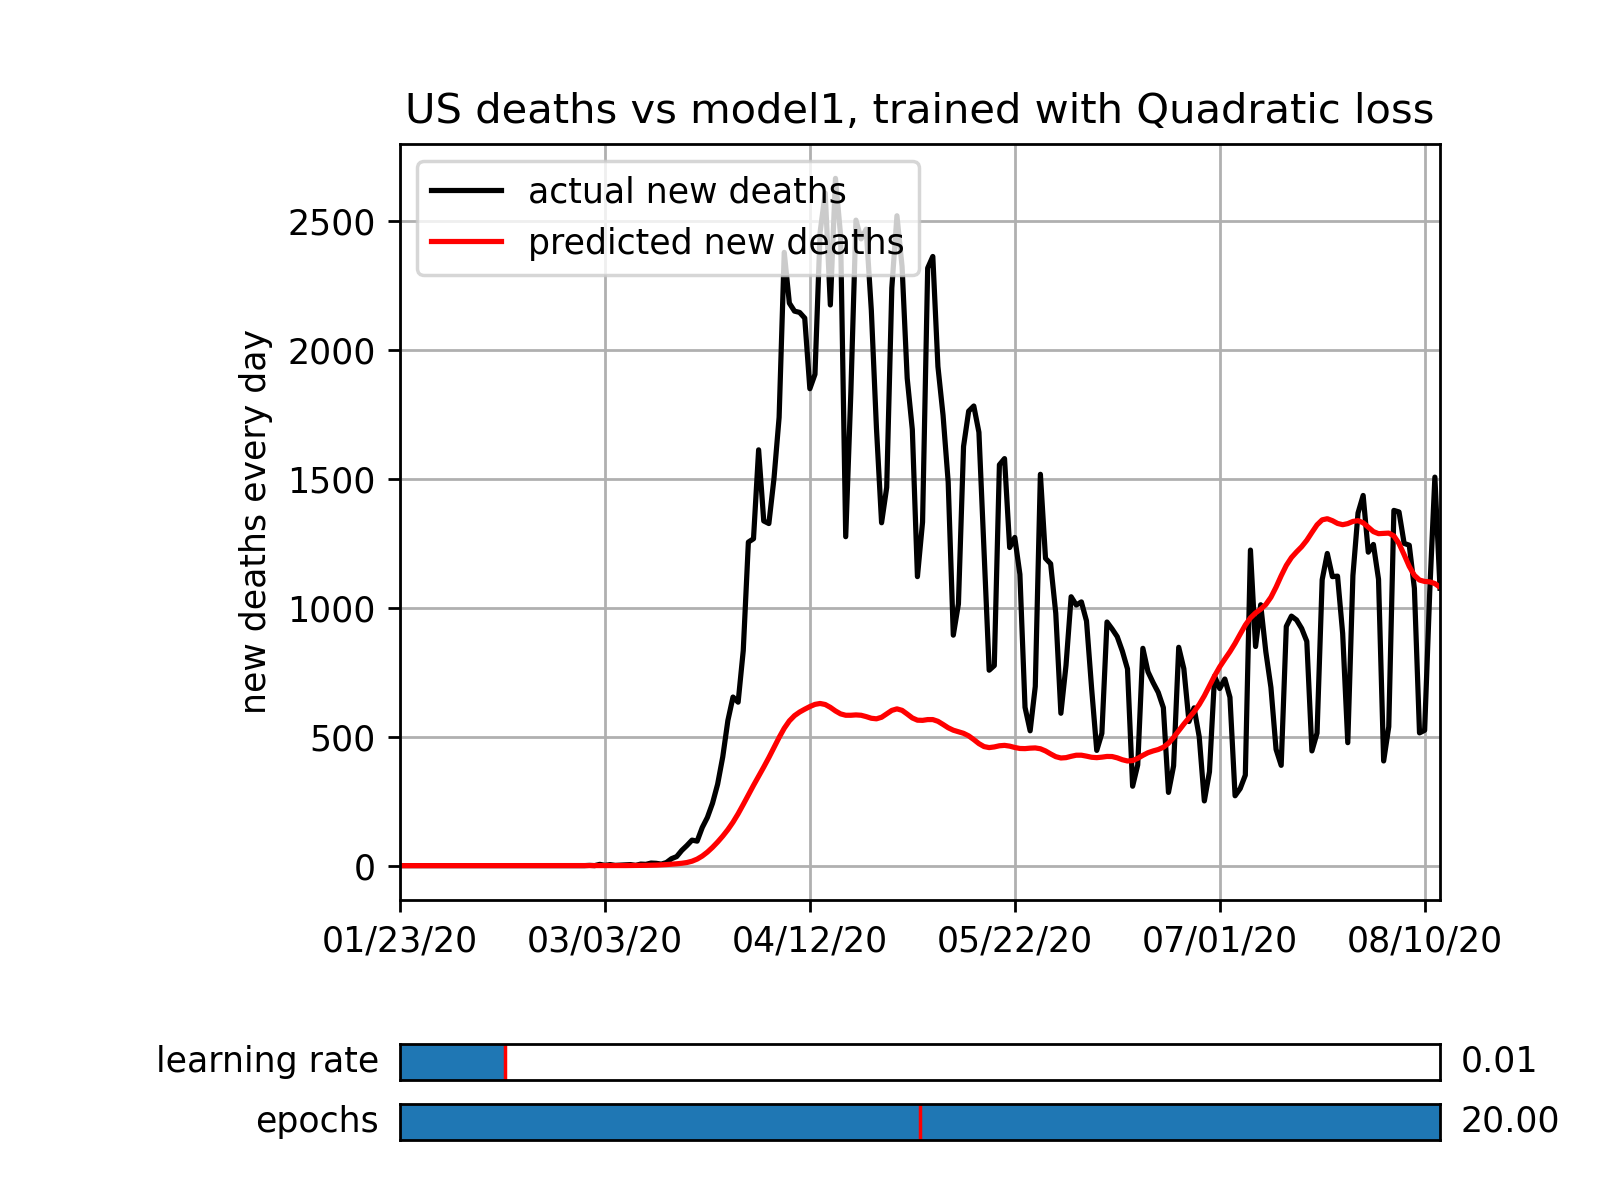

In [26]:


epoch_init=10
learning_rate_init=0.01

p_death=p_death_simple(0.02)
L=Lambda(6)
model3=model(USdeltacases,p_death,L)


for epoch in range(epoch_init):
    loss=Quadratic_loss(model3.get_predicted_deaths(),USdeltadeaths)
    model3.update(loss, learning_rate_init)


%matplotlib notebook
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
ax.margins(x=0)
    
plt.title('US deaths vs model1, trained with Quadratic loss')
plt.ylabel('new deaths every day')
plt.grid()
    
x=np.arange(0,USdeltadeaths.shape[0],1)
r, =plt.plot(x,USdeltadeaths,c='k',label="actual new deaths")
p, =plt.plot(x,model2.get_predicted_deaths(),c='r',
                label="predicted new deaths")
plt.legend(loc='upper left')
ticks, dates= make_ticks('1/23/20',n_days=USdeltadeaths.shape[0], step=40)
plt.xticks(ticks, dates)

axepochs = plt.axes([0.25, 0.05, 0.65, 0.03])
slider_epochs=Slider(axepochs, "epochs",0,20,valinit=epoch_init,valstep=1)
                
axlearning_rate = plt.axes([0.25, 0.1, 0.65, 0.03])
slider_learning_rate = Slider(axlearning_rate, "learning rate",0.001,0.1,
                              valinit=learning_rate_init,valstep=0.01)

def update(val):
    
    learning_rate=slider_learning_rate.val
    epochs = slider_epochs.val
    
    p_death=p_death_simple(0.02)
    L=Lambda(6)
    model3=model(USdeltacases,p_death,L)
    epoch=0
    while epoch!=epochs:
        loss=Quadratic_loss(model3.get_predicted_deaths(),USdeltadeaths)
        model3.update(loss, learning_rate)
        epoch+=1
        
    p.set_ydata(model3.get_predicted_deaths())
        
    fig.canvas.draw_idle()
    
slider_epochs.on_changed(update)
slider_learning_rate.on_changed(update)
plt.show()

We could go on with a log loss, but it is already pretty clear, a model with a constant $p_{p_death}$ and $lambda$ doesn't really work that well, simply put it cannot predict the big rise in deaths between 4/12/20 and 5/22/20. In the next part, we will try again with a time dependent decaying function as $p_{death}$.